In [1]:
import os

from collections import deque
import importlib
import torch as T
import gymnasium as gym

import policygradient
importlib.reload(policygradient)

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

In [2]:
env_id = "LunarLander-v2"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  8
Sample observation [ 0.78027576 -0.02534464  4.130359    0.4067486   0.3303498   2.4888194
  0.43948272  0.82043976]


In [3]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [4]:
layer1 = 128
layer2 = 256
gamma = 0.99
learning_rate = 0.0001
episodes = 100_000
avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)

agent = policygradient.ReInforceBaseline(s_size, a_size, layer1, layer2, gamma = gamma)

In [5]:
log_file_name = os.path.join('.','artefacts',f'{env_id}_policygradient_baseline.csv')
model_file = os.path.join('.','models',f'{env_id}_policygradient_baseline.pth')

In [6]:
train = False
if train:
    log_file = open(log_file_name, "w")
    log_file.write(f'episode,loss,rewards\n')

for epi in range(episodes):

    if not train:
        print("set train flag to True for Training")
        break

    s = env.reset()[0]
    done = False
    rewards, states , actions = [], [], []
    
    while not done:

        states.append(s)
        obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = agent.policy_net(obs)
            p_vals = T.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)

        s_, r, done ,_ , _  = env.step(a)
        actions.append(a)
        rewards.append(r)
        
        if np.sum(rewards)<-250:
            done = True
            
        s=np.copy(s_)

    epi_results.append(np.sum(rewards))
    loss = agent.train(states, rewards, actions, loss_scaler = 0.001)
    
    log_file.write(f'{epi},{loss:.2f},{np.sum(rewards):.2f}\n')

    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f} mean_rewards:{np.mean(epi_results):8.2f}')
    if np.mean(np.mean(epi_results))>220:
        break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

epi:01200 reward:   -1.98 loss:   -8.31 mean_rewards:  116.31
epi:01210 reward:  215.04 loss:    3.32 mean_rewards:  142.92
epi:01220 reward:  207.39 loss:    3.28 mean_rewards:  160.87
epi:01230 reward:  256.14 loss:    8.69 mean_rewards:  196.34
epi:01240 reward:  303.47 loss:   10.19 mean_rewards:  205.17
epi:01250 reward:  214.69 loss:   -3.63 mean_rewards:  214.72
Saving Agent as .\models\LunarLander-v2_policygradient_baseline.pth


In [7]:
eval_agent =  policygradient.ReInforceBaseline(s_size, a_size, layer1, layer2, gamma = gamma)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Loss')

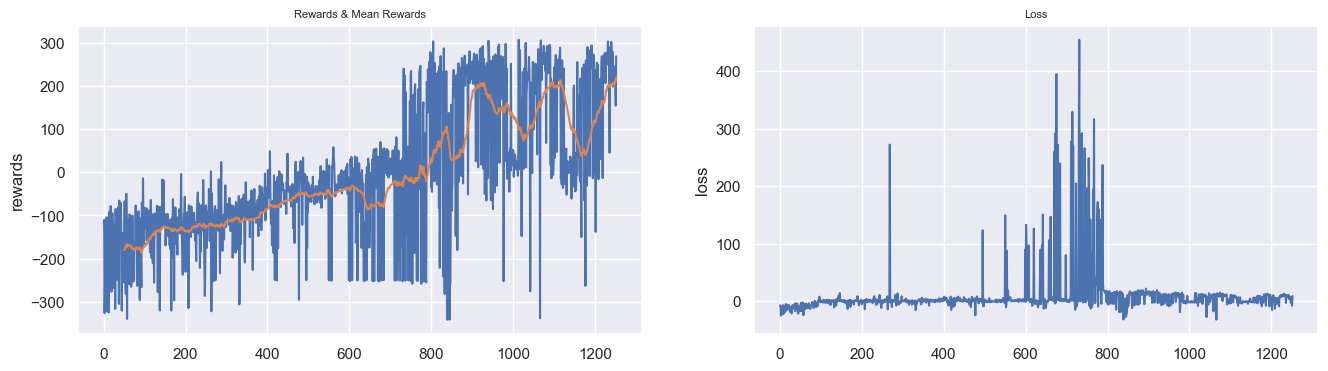

In [8]:
fig,ax=plt.subplots(1,2,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)

In [11]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0

    while not any([term, trunc]):

        obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = eval_agent.policy_net(obs)
            p_vals = T.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        
        score+=r
        
    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result -14.92
epi = 1 result -82.49
epi = 2 result -25.13
epi = 3 result -29.53
epi = 4 result -32.35
epi = 5 result -13.36
epi = 6 result 138.33
epi = 7 result -51.14
epi = 8 result 133.90
epi = 9 result -5.18
